In [10]:
from quantum_logical.channel import (
    AmplitudeDamping,
    PhaseDamping,
)
from quantum_logical.trotter.trotter import TrotterGroup
import numpy as np
import matplotlib.pyplot as plt

from qutip.core.metrics import fidelity

# from qutip.operators import sigmaz
from qutip import basis
from qutip import expect
from qutip import qeye, tensor
from tqdm import tqdm
from qutip import sigmaz

In [2]:
# Define the number of qubits
N = 2  # Number of qubits
delays = np.linspace(0, 25, 40)  # Sweeping delay from 0 to 10

# Assuming all qubits have the same T1 and T2
T1, T2 = 1, 1

trotter_step_size = 0.2

# Create initial states for a N-qubit system
zero_rho = basis(2, 0) * basis(2, 0).dag()  # |0><0| state for a single qubit
one_rho = basis(2, 1) * basis(2, 1).dag()  # |1><1| state for a single qubit

# Define the N-qubit initial state |11...1> (N ones)
initial_state = tensor([one_rho] * N)
initial_state /= initial_state.norm()

# Define a N-qubit GHZ state (density matrix)
ghz_state = tensor([one_rho] * N) + tensor([zero_rho] * N)
ghz_state /= ghz_state.norm()

In [3]:
def multi_qubit_experiment(rho_initial, delay, trotter_step_size, unitary=None):
    amp_damp_channel = AmplitudeDamping(T1, num_qubits=N)
    phase_damp_channel = PhaseDamping(T1, T2, num_qubits=N)

    trotter = TrotterGroup(
        continuous_operators=[amp_damp_channel, phase_damp_channel],
        trotter_dt=trotter_step_size,
    )

    rho_final = trotter.apply(rho_initial, delay, discrete_unitary=unitary)

    if unitary is None:
        rho_expected = rho_initial
    else:
        rho_expected = unitary * rho_initial * unitary.dag()

    # Calculate the fidelity
    fid = qt.fidelity(rho_expected, rho_final)
    return rho_final, fid

In [4]:
# Define the observables for the N-qubit system and create a dictionary to hold the observables with their labels
def define_observables(N):
    observable_labels = []
    observables = {}

    # Start with all Zs and successively replace one Z with I from right to left
    for num_z in range(N, -1, -1):  # Start with N Z's, down to 0 Z's
        label = "".join(["Z" if i < num_z else "I" for i in range(N)])
        observable_labels.append(label)
        observables[label] = tensor(
            *([sigmaz() if i < num_z else qeye(2) for i in range(N)])
        )

    return observables, observable_labels


# Generate the observables and their labels
observables, observable_labels = define_observables(N)

In [5]:
def plot_observable_decay(
    state, observables, observable_labels, delays, trotter_step_size
):
    plt.figure(figsize=(4, 4))

    # Precompute the final states for each delay
    final_states = []
    for delay in tqdm(delays):
        rho_final, _ = multi_qubit_experiment(
            state, delay, trotter_step_size=trotter_step_size
        )
        final_states.append(rho_final)

    # Calculate and plot expectation values for each observable
    for label in observable_labels:
        obs = observables[label]
        exp_values = [expect(obs, rho_final) for rho_final in final_states]
        plt.plot(delays, exp_values, "-.", label=label)

    plt.legend()
    plt.xlabel("Delay")
    plt.ylabel("Expectation Value")
    plt.title("Observable Expectation Values Over Time")
    plt.show()

100%|██████████| 40/40 [00:00<00:00, 134.84it/s]


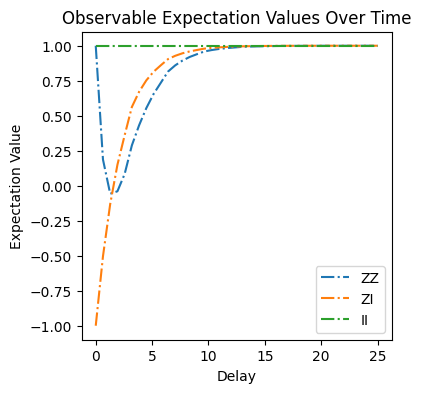

In [11]:
# Now call the updated function with labels
plot_observable_decay(
    initial_state,
    observables,
    observable_labels,
    delays,
    trotter_step_size,
)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 108.76it/s]


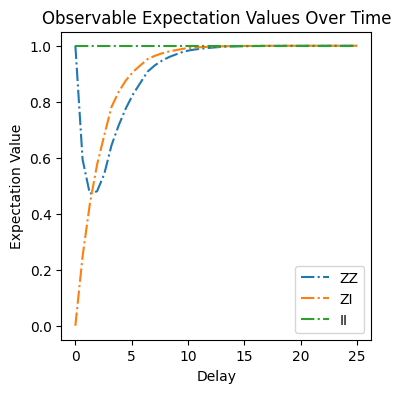

In [ ]:
# Now call the updated function with labels
plot_observable_decay(
    ghz_state,
    observables,
    observable_labels,
    delays,
    trotter_step_size,
)